In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter 
import os
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import zipfile
import shutil
from tensorflow.keras.utils import plot_model
import graphviz

In [2]:
## Defining batch specfications
batch_size = 100
img_height = 250
img_width = 250

In [3]:
zip_file_path = r"G:\data.zip"
extracted_dir = 'data_extracted'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Define the directories for train, validation, and test datasets
train_dir = os.path.join(extracted_dir, 'train')
val_dir = os.path.join(extracted_dir, 'val')
test_dir = os.path.join(extracted_dir, 'test')

In [4]:
training_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 791 files belonging to 2 classes.


In [5]:
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 98 files belonging to 2 classes.


In [6]:
testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 100 files belonging to 2 classes.


In [7]:
testing_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
class_names = training_data.class_names
class_names

['Accident', 'Non Accident']

In [9]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_data = training_data.cache().prefetch(buffer_size=AUTOTUNE)
testing_data = testing_data.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
## Defining Cnn
model = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'), # Conv2D(f_size, filter_size, activation) # relu, sigmoid, softmax
  layers.MaxPooling2D(), # MaxPooling
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(len(class_names), activation= 'softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.build((None, 250, 250, 3))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 250, 250, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 248, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 27, 27, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    22,151,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,541,134 (85.99 MB)

 Trainable params: 22,541,128 (85.99 MB)

 Non-trainable params: 6 (24.00 B)

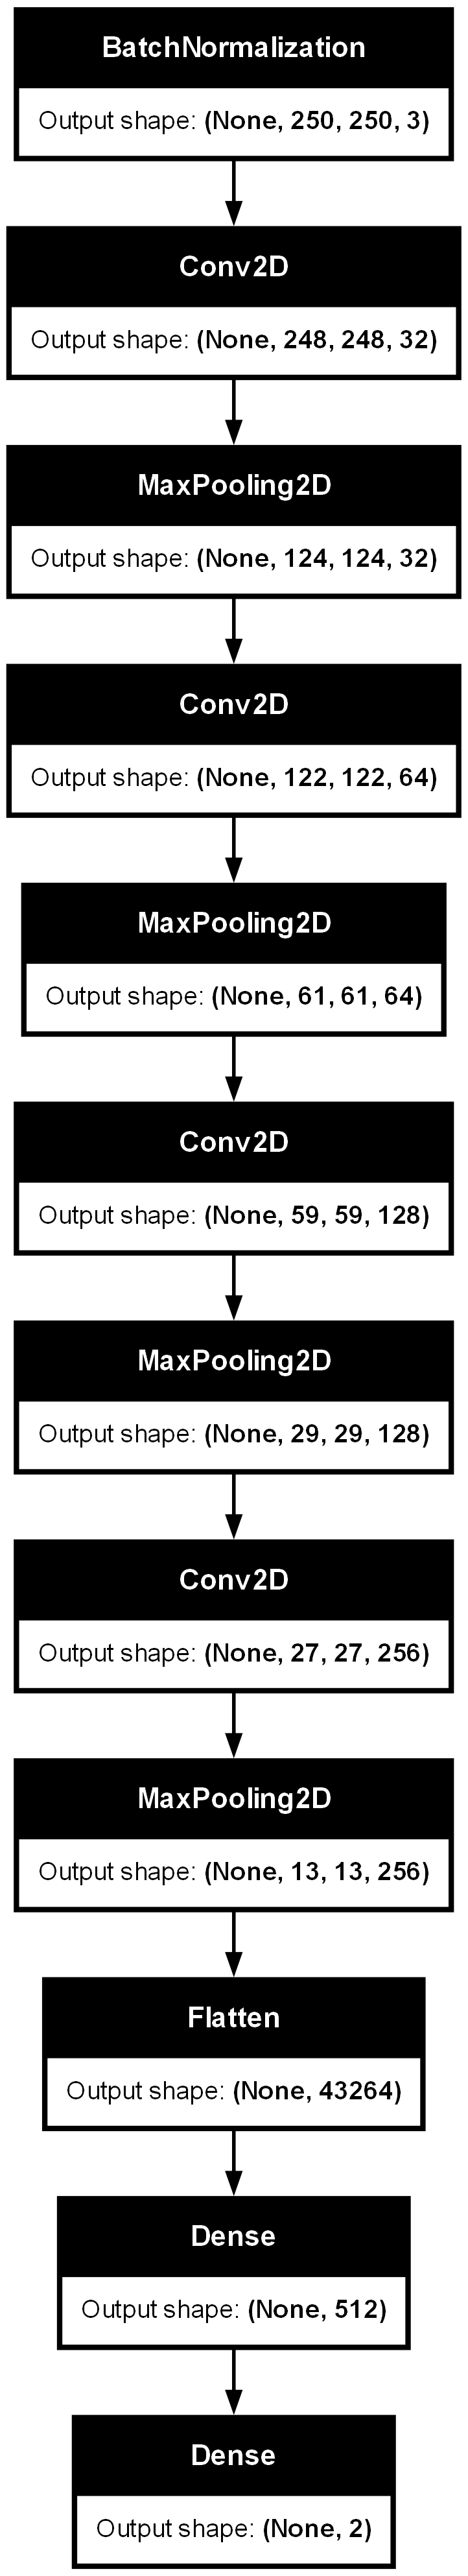

In [12]:
plot_model(model, show_shapes=True)

In [13]:
checkpoint = ModelCheckpoint("model_weights.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(training_data, validation_data=validation_data, epochs=20, callbacks=callbacks_list)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4994 - loss: 5.2058
Epoch 1: val_accuracy improved from -inf to 0.62245, saving model to model_weights.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.5010 - loss: 5.0062 - val_accuracy: 0.6224 - val_loss: 0.6520
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5630 - loss: 0.6806
Epoch 2: val_accuracy did not improve from 0.62245
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.5641 - loss: 0.6798 - val_accuracy: 0.5306 - val_loss: 0.8455
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6131 - loss: 0.6416
Epoch 3: val_accuracy improved from 0.62245 to 0.69388, saving model to model_weights.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.6155 - loss: 0.6406 - val_accuracy: 0.6939 - val_loss: 0.5983
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6741 - loss: 0.5904
Epoch 4: val_accuracy did not improve from 0.69388
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.676

In [14]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

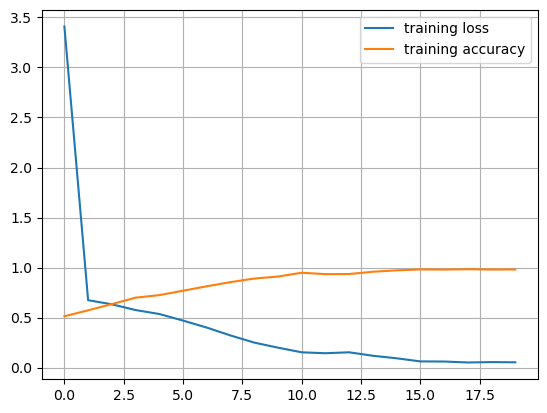

In [15]:
## stats on training data
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

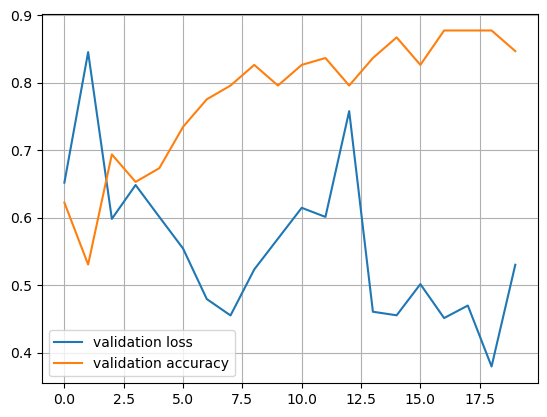

In [16]:
## stats on training data
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


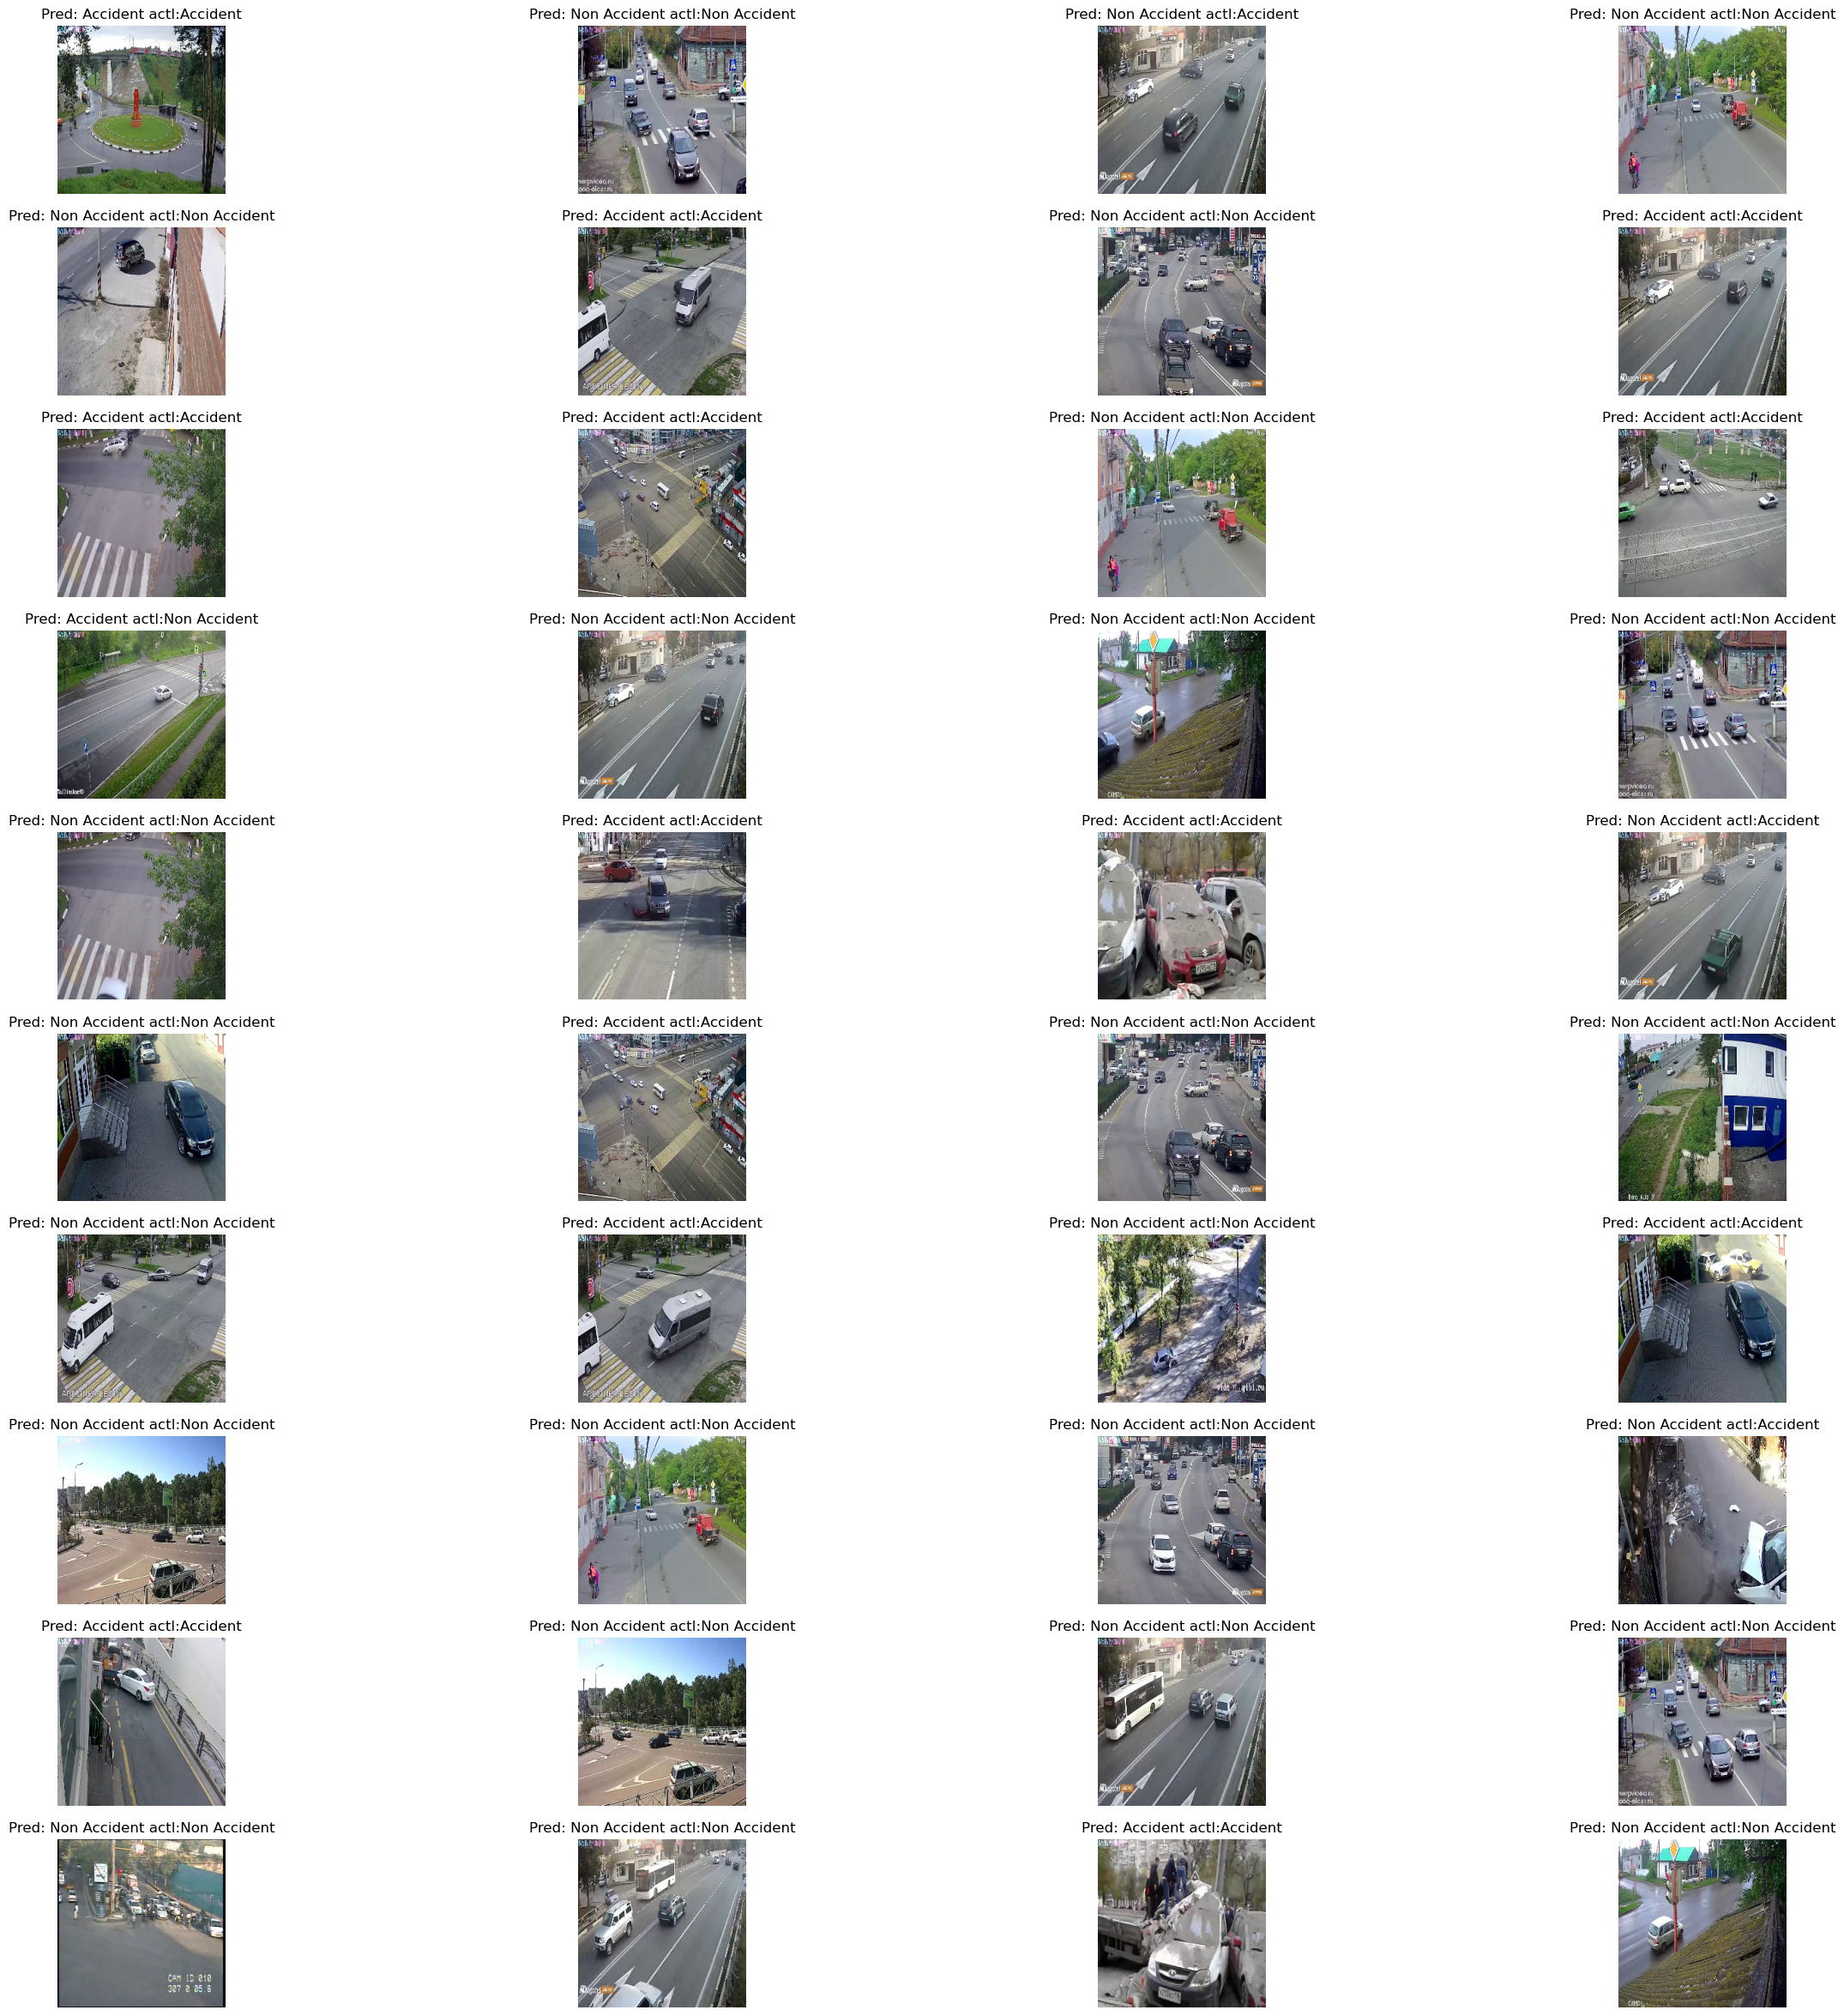

In [17]:
## lets vizualize results on testing data
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in testing_data.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

In [18]:
from keras.models import model_from_json
import numpy as np

class AccidentDetectionModel(object):

    class_nums = ['Accident', "No Accident"]

    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        self.loaded_model.make_predict_function()

    def predict_accident(self, img):
        self.preds = self.loaded_model.predict(img)
        return AccidentDetectionModel.class_nums[np.argmax(self.preds)], self.preds

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


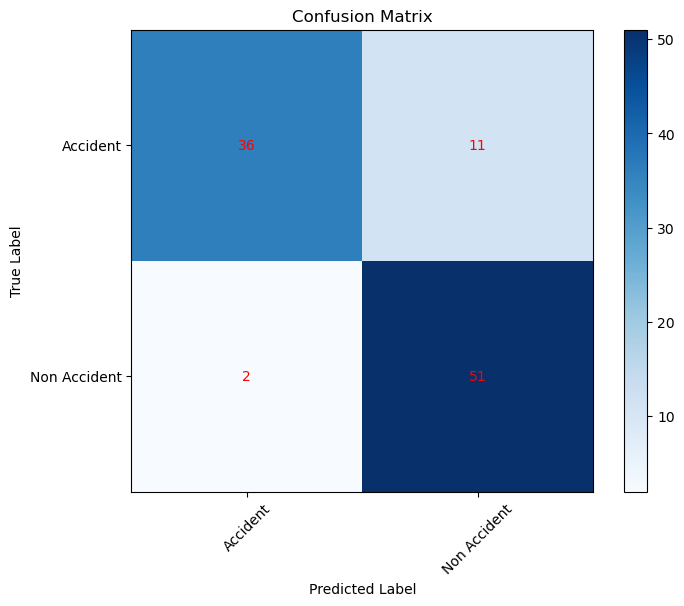

F1 Score: 0.8869565217391304


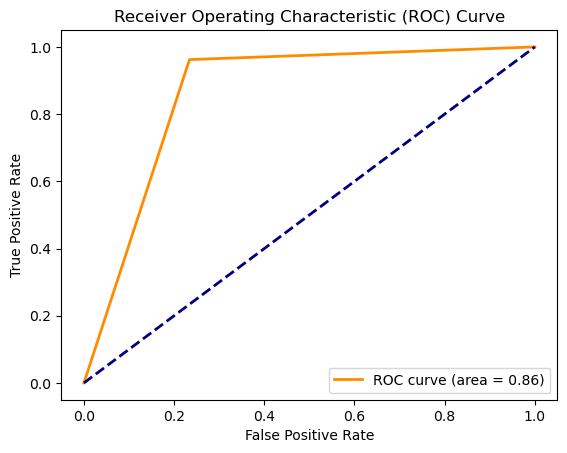

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.colorbar()
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='red')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Generate predictions for the testing dataset
y_true = []  # True labels
y_pred = []  # Predicted labels

for images, labels in testing_data:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)

# Calculate F1 score
f1 = f1_score(y_true, y_pred)
print("F1 Score:", f1)

# Plot ROC curve
plot_roc_curve(y_true, y_pred)


In [ ]:
import numpy as np
import os
import cv2

model = AccidentDetectionModel("model.json", 'model_weights.keras')
font = cv2.FONT_HERSHEY_SIMPLEX

def startapplication():
    video = cv2.VideoCapture('F:/acci vo.mp4')  # Specify the correct file path
    while True:
        ret, frame = video.read()
        if not ret:
            print("Failed to read frame. Exiting...")
            break
        
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        roi = cv2.resize(gray_frame, (250, 250))

        pred, prob = model.predict_accident(roi[np.newaxis, :, :])
        if pred == "Accident":
            prob = round(prob[0][0] * 100, 2)
            
            # To beep when alert:
            # if prob > 90:
            #     os.system("say beep")

            cv2.rectangle(frame, (0, 0), (280, 40), (0, 0, 0), -1)
            cv2.putText(frame, pred + " " + str(prob), (20, 30), font, 1, (255, 255, 0), 2)

        if cv2.waitKey(33) & 0xFF == ord('q'):
            break
        cv2.imshow('Video', frame)  

    # Release the video capture object and close all OpenCV windows
    video.release()
    cv2.destroyAllWindows()

if __name__ == '__main__':
    startapplication()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━